<a href="https://colab.research.google.com/github/rostiman1/DeepLearningUnit/blob/main/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Networks

Welcome to the eight lab exercise. In this notebook, you will:

- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train the network for image classification. 

In the previous exercise, you have learnt how to use keras to build a simple convolutional neural network and in this exercise, you will use the same functions to build a very deep convolutional networks called Residual networks. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks.

#####**NOTE: Use GPU at runtime type for this lab exercise**

## Recommended Reading

- Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf)
- CNN Residual Networks, [notes](http://datahacker.rs/deep-learning-residual-networks/)
- [Understanding and implementation of ResNets](https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c)
- [Why Resnets Works](https://www.coursera.org/lecture/convolutional-neural-networks/why-resnets-work-XAKNO)
- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

#### Other CNN architecture implementations
- VGG16 implementation [step by step](https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c)
- AlexNet implementation [step by step](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98)
- LeNet Implementation [step by step](https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9)




Let's get started

First of all, mount google drive.
This will mount the google drive for google colab and you will be able access contents of your drive.

In [74]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/My Drive/Deep_learning_unit/Assignment8')
folder = os.path.join('/content/drive/My Drive/Deep_learning_unit/Assignment8')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Assignment8.ipynb  images    model.png	  resnets_utils.py
datasets	   __MACOSX  __pycache__


## Packages

First, let's run the cell below to import all the packages that you will need during this exercise.
- [keras](https://keras.io) is high level API and the most used deep learning framework. Built on top of TensorFlow 2.0, Keras is an industry-strength framework that can scale to large clusters of GPUs.
- [tensorflow](https://www.tensorflow.org) is the library which provides the functions for deep neural networks.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.

In [75]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## 1 - The problem of very deep neural networks

Last week, you built your first convolutional neural network. In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

* One of the major benefits of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 
* However, a huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.
* More specifically, during gradient descent, as we backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 
* The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds. 

In theory, we expect having a deeper network should only help but in reality, the deeper network has higher training error, and thus test error. The figure below shows Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “classic” networks. The deeper network has higher training error, and thus test error. In classic networks, as the number of layers increase from 20 to 56 (as shown below), even after thousands of iterations, training error was worse for a 56 layer compared to a 20 layer network.


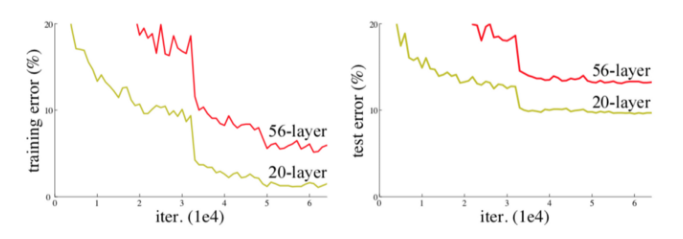

In [76]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/plain_networks.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers. The approach is to add a shortcut or a skip connection that allows information to flow, well just say, more easily from one layer to the next’s next layer, i.e., you bypass data along with normal CNN flow from one layer to the next layer after the immediate next. The residual block looks like:



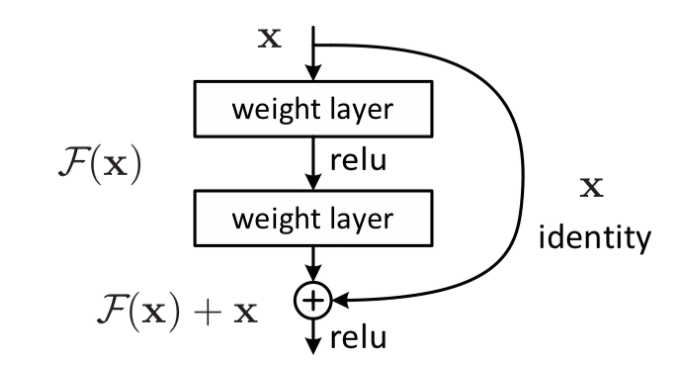

In [77]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/Residual_block.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

By stacking these ResNet blocks on top of each other, you can form a very deep network. 

ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
(There is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more so than skip connections helping with vanishing gradients).

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different:
- Identity block
- Convolutional block

### 2.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

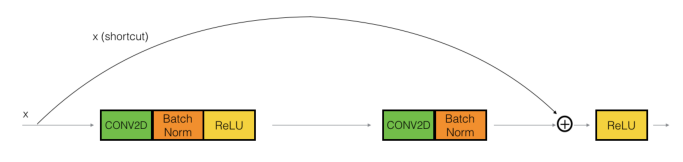

In [78]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/idblock2_kiank.png')
plt.imshow(img)
plt.axis('off') 
plt.show()


The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 


In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

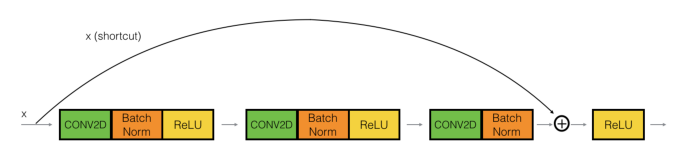

In [79]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/idblock3_kiank.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

Here are the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. 
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Note:** Use `kernel_initializer = glorot_uniform(seed=0)` for kernel initialization. Use the following sample codes to get started with the functions.

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [Batch Normalization](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the 'channels' axis) where the dimension order are [batch, height, width, channel])
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://keras.io/layers/merge/#add)

In [80]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    ### START CODE HERE ###

    # First component of main path (≈3 lines)
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)



    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    ### END CODE HERE ###
    
    return X

## 2.2 - The convolutional block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

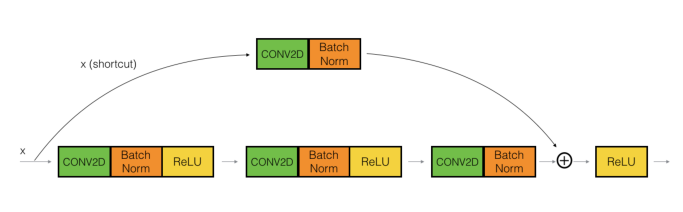

In [81]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/convblock.png')
plt.imshow(img)
plt.axis('off') 
plt.show()



* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the `glorot_uniform` seed.
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.  Use 0 as the `glorot_uniform` seed.
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.  Use 0 as the `glorot_uniform` seed.
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.  Use 0 as the `glorot_uniform` seed.
- The BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    

**Implement the convolutional block.** 

 As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- [BatchNormalization](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://keras.io/layers/merge/#add)

In [100]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ### START CODE HERE ###
    ##### MAIN PATH #####
    # First component of main path (≈3 lines)
    X = Conv2D(F1,(1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(F2,(f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3,(1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE ###
    
    return X

## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

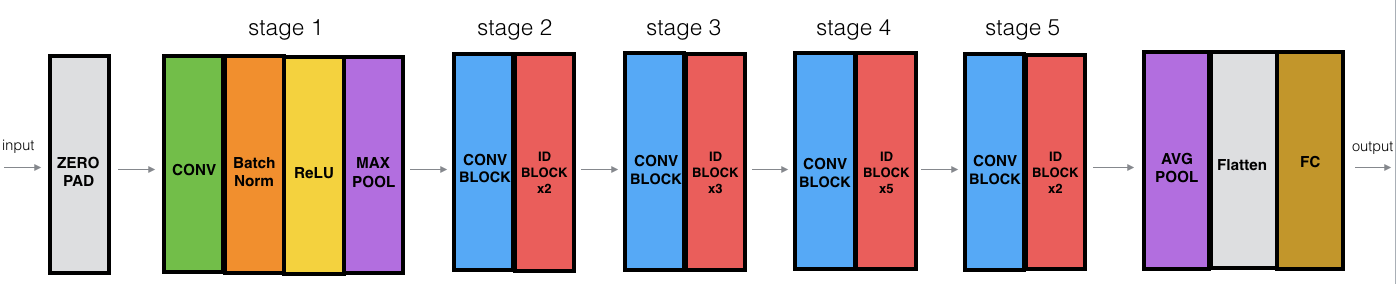

In [83]:
from IPython.display import Image 
Image(open('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/resnet.png','rb').read())

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the 'channels' axis of the input and name is "bn_conv1".
    - MaxPooling2D uses a (3,3) window and a stride of (2,2).
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The 'flatten' layer doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

 **Implement the ResNet with 50 layers described in the figure above.** 
 
The syntax for implementing Stages 1-5 should be quite similar as before. Make sure you follow the naming convention in the text above. 

You'll need to use this function: 
- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully connected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [96]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    ### START CODE HERE ###
    
    # Stage 1 (≈4 lines)
    X = Conv2D(64, (7, 7),strides =(2,2),name = 'conv1',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis =3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X) 

    # Stage 2 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph. If your implementation is not correct you will know it by checking your accuracy when running `model.fit(...)` below.

In [99]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

As seen in the Keras Tutorial Notebook, prior training a model, you need to configure the learning process by compiling the model.

You can compile the model by using the following `model.compile(args)` where args are the parameters which are passed as:

- `loss` - In order to find good values for the CNN weights we use  `loss = 'categorical_crossentropy'` for multiclass classification.

- `optimizer` - We can specify optimizer RMSprop as follows: `optimizer='adam'`

**Note!** Other optimizers, such as Adam, also automatically adapt the learning rate during training, and would work equally well here.

- `metrics` - the metrics we want to compute and we generally compute accuracy and is given as `metrics=['accuracy']`

In [106]:
# Compile your model
### Start CODE HERE ### (1 lines of code)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
### End CODE HERE ###

The model is now ready to be trained. The only thing you need is a dataset.

Let's load the SIGNS Dataset.

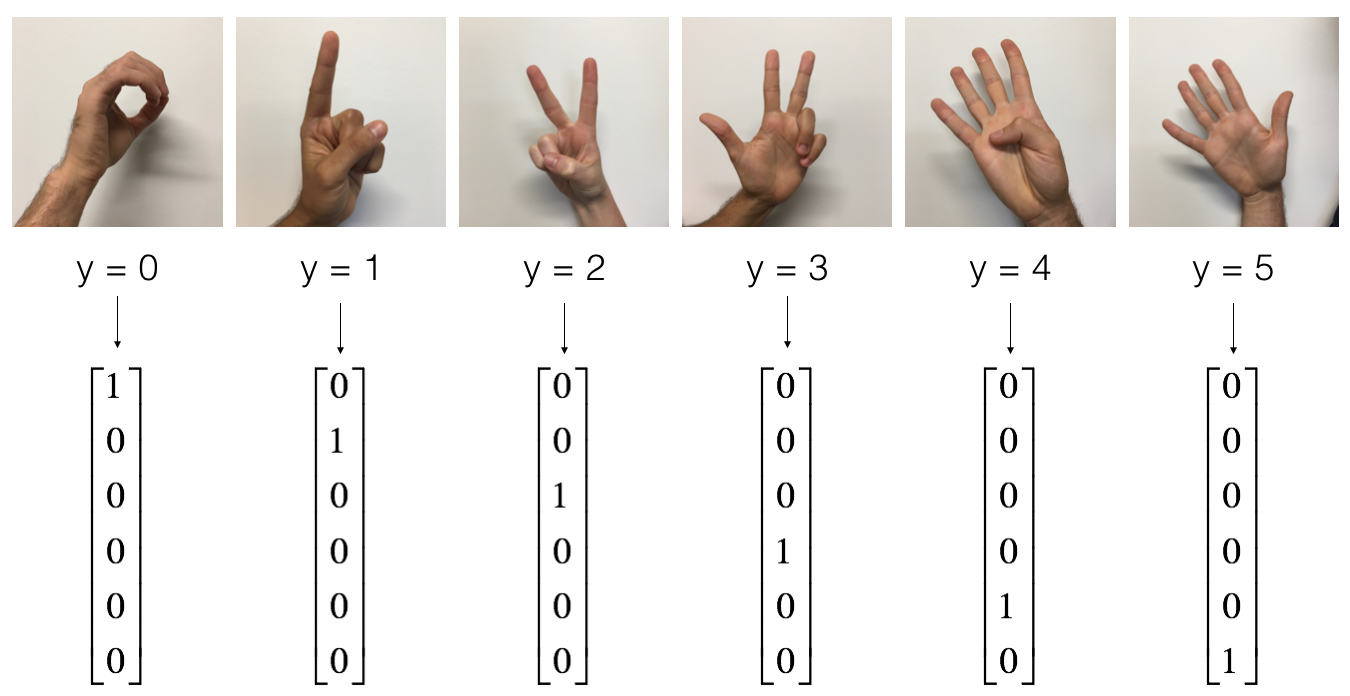

In [87]:
from IPython.display import Image 
Image(open('/content/drive/My Drive/Deep_learning_unit/Assignment8/images/signs.png','rb').read())

In [101]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run the following cell to train your model on 100 epochs with a batch size of 32. On a GPU it should take you around around 5 mins. Fit the model by giving the parameters as X_train, Y_train, epochs = 100 and batch_size = 32.

In [107]:
### START CODE HERE ### (≈1 line)
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)
### END CODE HERE ###

Epoch 1/2
34/34 [==============================] - 9s 63ms/step - loss: 3.6940 - accuracy: 0.2815
Epoch 2/2
34/34 [==============================] - 1s 41ms/step - loss: 1.3114 - accuracy: 0.5602


**Expected Output**:

<table>
    <tr>
        <td>
            ** Epoch 1/100**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different.
        </td>
    </tr>

</table>

Let's see how this model performs on the test set.

In [108]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 16ms/step - loss: 1.8556 - accuracy: 0.1667
Loss = 1.8555903434753418
Test Accuracy = 0.1666666716337204


**Expected Output**:

<table>
    <tr>
        <td>
            **Test Accuracy**
        </td>
        <td>
           More than 0.85
        </td>
    </tr>

</table>

ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. We hope you can use what you've learnt and apply it to your own classification problem to perform state-of-the-art accuracy.



You can also print a summary of your model by running the following code.

In [109]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 70, 70, 3)   0           ['input_11[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d_10[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']           

Finally, run the code below to visualize your ResNet50. You can also download a .png picture of your model by going to "File -> Open...-> model.png".

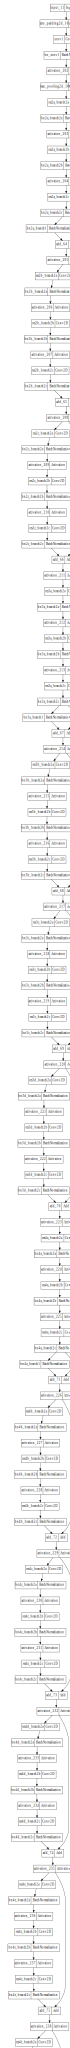

In [110]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Congratulations on finishing this exercise! You've now implemented a state-of-the-art image classification system! 